# Q5: The recognition of apples

### 1. Import Libraries

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import torch
import os       
from torch import nn 
import torch.nn.functional as F
from torch.optim import lr_scheduler
import torch.cuda
import time
from torch.utils.data import random_split
from torch.utils.data import TensorDataset, DataLoader
%matplotlib inline 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 2. Hyperparameters

In [2]:
# HYPERPARAMS
FILTER_SIZE_1 = 3     # Convolutional Layer 1
FILTER_NUM_1 = 32
FILTER_SIZE_2 = 3     # Convolutional Layer 2
FILTER_NUM_2 = 32
FILTER_SIZE_3 = 3     # Convolutional Layer 3
FILTER_NUM_3 = 64
FC_SIZE = 128         # Number of neurons in fully-connected layer
H_IMG, W_IMG, C_IMG = 180, 270, 3
CLASSES = ['apple', 'carambola', 'pear', 'plum', 'tomato']
NUM_CLASSES = len(CLASSES)
BATCH_SIZE = 32
DATASET_SIZE = 20705
SPLIT_PROPORTION = 0.2
CHECKPOINT_DIR = "../models/"
EPOCHS = 20
LEARNING_RATE = 1e-5
WEIGHT_DECAY = 5e-4
VALID_DATA_PATH = "../Attachment/Attachment 3/"
DATA_PATH = "../Attachment/Attachment 2/"

### 3. Data preprocessing

In [3]:

data_x = []
data_y = []
index = -1
#data_limit_for_each_class = 2000
for path in os.listdir(DATA_PATH):
    index += 1
    data_count = 0
    for img in os.listdir(DATA_PATH + path):
        data_count += 1
        image = cv2.imread(DATA_PATH + path + "/" + img)
        data_x.append(image)
        data_y.append(index)
        '''if data_count >= data_limit_for_each_class:
            break'''
data_x = np.array(data_x) / 255.0
data_y = np.array(data_y)
print(data_x.shape)
print(data_y.shape)

(20705, 180, 270, 3)
(20705,)


In [4]:
data_x = torch.tensor(np.array(data_x))       
data_y = torch.tensor(np.array(data_y)).long()    
dataset = TensorDataset(data_x, data_y)
train_size = int(DATASET_SIZE * (1-SPLIT_PROPORTION))
test_size = DATASET_SIZE - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
data_loader_train = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
data_loader_test = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 4. CNN Model

In [5]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(C_IMG, FILTER_NUM_1, FILTER_SIZE_1, padding=FILTER_SIZE_1//2)
        self.conv2 = nn.Conv2d(FILTER_NUM_1, FILTER_NUM_2, FILTER_SIZE_2, padding=FILTER_SIZE_2//2)
        self.conv3 = nn.Conv2d(FILTER_NUM_2, FILTER_NUM_3, FILTER_SIZE_3, padding=FILTER_SIZE_3//2)

        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # Calculate the size of the flattened layer
        self.fc1_size = self._get_conv_output((C_IMG, H_IMG, W_IMG))
        self.fc1 = nn.Linear(self.fc1_size, FC_SIZE)
        self.fc2 = nn.Linear(FC_SIZE, NUM_CLASSES)

    def forward(self, x):
        x = x.float().to(device)
        
        # Reorder to [BATCH_SIZE, channels, height, width]
        x = x.permute(0, 3, 1, 2)  
        
        # Apply convolutions and max pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the output for the dense layer
        x = x.reshape(-1, self.fc1_size)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def _get_conv_output(self, shape):
        with torch.no_grad():
            input = torch.rand(1, *shape)
            output = self._forward_features(input)
            return int(np.prod(output.size()))

    def _forward_features(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        return x

model = ConvNet().to(device)
print(model)

ConvNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=46464, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=5, bias=True)
)


### 5. Model Training

In [6]:
def test(loss_function, scheduler, A_LS2, P_LS2, R_LS2, F1_LS2):    # Test the model training on test set
    sum_true = 0
    model.eval()
    TP2 = [0] * NUM_CLASSES
    FP2 = [0] * NUM_CLASSES
    FN2 = [0] * NUM_CLASSES
    TN2 = [0] * NUM_CLASSES
    with torch.no_grad():
        for data in data_loader_test:
            batch_x, batch_y = data[0].to(device), data[1].to(device)
            y_hat = model(batch_x)
            #test_loss = loss_function(y_hat, batch_y)
            y_hat = torch.tensor([torch.argmax(_) for _ in y_hat]).to(device)
            sum_true += torch.sum(y_hat == batch_y).float()
            #scheduler.step(test_loss)
            for i in range(NUM_CLASSES):
                TP2[i] += torch.sum((y_hat == i) & (batch_y == i)).item()
                FP2[i] += torch.sum((y_hat == i) & (batch_y != i)).item()
                FN2[i] += torch.sum((y_hat != i) & (batch_y == i)).item()
                TN2[i] += torch.sum((y_hat != i) & (batch_y != i)).item()
        test_acc = sum_true / test_size      
        precision2 = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(TP2, FP2)]
        recall2 = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(TP2, FN2)]
        f12 = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision2, recall2)]
        macro_precision2 = sum(precision2) / NUM_CLASSES
        macro_recall2 = sum(recall2) / NUM_CLASSES
        macro_f12 = sum(f12) / NUM_CLASSES
        A_LS2.append(test_acc)
        P_LS2.append(macro_precision2)
        F1_LS2.append(macro_f12)
        R_LS2.append(macro_recall2)
        return test_acc, macro_precision2, macro_recall2, macro_f12, A_LS2, P_LS2, R_LS2, F1_LS2

In [7]:
final_y_hat = []
loss_function = nn.CrossEntropyLoss()                                       # 设置损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)  # 设置优化器
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)
A_LS, P_LS, R_LS, F1_LS = [],[],[],[]
A_LS2, P_LS2, R_LS2, F1_LS2 = [],[],[],[]
for epoch in range(EPOCHS+1):
    TP = [0] * NUM_CLASSES
    FP = [0] * NUM_CLASSES
    FN = [0] * NUM_CLASSES
    TN = [0] * NUM_CLASSES
    sum_true = 0
    sum_loss = 0.0
    max_test_acc = 0
    model.train()
    index = 0
    total_data = len(data_loader_train)
    for data in data_loader_train:
        index += 1
        #print('Training batch {}/{}'.format(index,total_data),end='\r')
        batch_x, batch_y = data[0].to(device), data[1].to(device)
        y_hat = model(batch_x)
        loss = loss_function(y_hat, batch_y)
        if epoch == EPOCHS:
            final_y_hat += y_hat
        optimizer.zero_grad()   # Zeroing the gradients
        loss.backward()         # Calculate gradients
        optimizer.step()        # Update params
        with torch.no_grad():
            y_hat = torch.tensor([torch.argmax(_) for _ in y_hat]).to(device)
            sum_true += torch.sum(y_hat == batch_y).item()
            sum_loss += loss.item()
            for i in range(NUM_CLASSES):
                TP[i] += torch.sum((y_hat == i) & (batch_y == i)).item()
                FP[i] += torch.sum((y_hat == i) & (batch_y != i)).item()
                FN[i] += torch.sum((y_hat != i) & (batch_y == i)).item()
                TN[i] += torch.sum((y_hat != i) & (batch_y != i)).item()

    train_acc = sum_true / train_size    # Caluculate accuracy and loss
    train_loss = sum_loss / train_size
    precision = [tp / (tp + fp) if (tp + fp) > 0 else 0 for tp, fp in zip(TP, FP)]
    recall = [tp / (tp + fn) if (tp + fn) > 0 else 0 for tp, fn in zip(TP, FN)]
    f1 = [2 * p * r / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
    macro_precision = sum(precision) / NUM_CLASSES
    macro_recall = sum(recall) / NUM_CLASSES
    macro_f1 = sum(f1) / NUM_CLASSES
    A_LS.append(train_acc)
    P_LS.append(macro_precision)
    F1_LS.append(macro_f1)
    R_LS.append(macro_recall)

    test_acc, macro_precision2, macro_recall2, macro_f12, A_LS2, P_LS2, R_LS2, \
        F1_LS2 = test(loss_function, scheduler, A_LS2, P_LS2, R_LS2, F1_LS2)
    if test_acc > max_test_acc:
        torch.save(model, CHECKPOINT_DIR+"checkpoint.pt")
    if epoch % 2 == 0:
        print(f"EP:{epoch}, loss:{train_loss:.4f}, TRAIN A:{train_acc*100:.2f}%, P:{macro_precision*100:.2f}%, R:{macro_recall*100:.2f}%, F1:{macro_f1*100:.2f}%, TEST A:{test_acc*100:.2f}%, P:{macro_precision2*100:.2f}%, R:{macro_recall2*100:.2f}%, F1:{macro_f12*100:.2f}%, time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime()) }")


EP:0, loss:0.0382, TRAIN A:53.32%, P:12.05%, R:19.90%, F1:14.18%, TEST A:54.70%, P:70.84%, R:21.75%, F1:17.45%, time: 2023-11-26 23:22:41
EP:2, loss:0.0170, TRAIN A:82.70%, P:87.98%, R:73.45%, F1:78.86%, TEST A:85.08%, P:90.40%, R:77.52%, F1:82.58%, time: 2023-11-26 23:23:21
EP:4, loss:0.0112, TRAIN A:88.22%, P:90.31%, R:83.63%, F1:86.51%, TEST A:86.69%, P:93.22%, R:78.73%, F1:84.15%, time: 2023-11-26 23:23:41
EP:6, loss:0.0089, TRAIN A:90.17%, P:91.99%, R:86.79%, F1:89.11%, TEST A:89.76%, P:93.49%, R:85.13%, F1:88.57%, time: 2023-11-26 23:24:00
EP:8, loss:0.0075, TRAIN A:91.93%, P:93.21%, R:89.53%, F1:91.23%, TEST A:91.55%, P:93.92%, R:88.36%, F1:90.77%, time: 2023-11-26 23:24:18
EP:10, loss:0.0066, TRAIN A:93.15%, P:94.28%, R:91.23%, F1:92.65%, TEST A:92.39%, P:94.14%, R:90.02%, F1:91.89%, time: 2023-11-26 23:24:38
EP:12, loss:0.0059, TRAIN A:93.89%, P:95.00%, R:92.23%, F1:93.53%, TEST A:92.92%, P:94.80%, R:90.50%, F1:92.50%, time: 2023-11-26 23:24:58
EP:14, loss:0.0052, TRAIN A:94.6

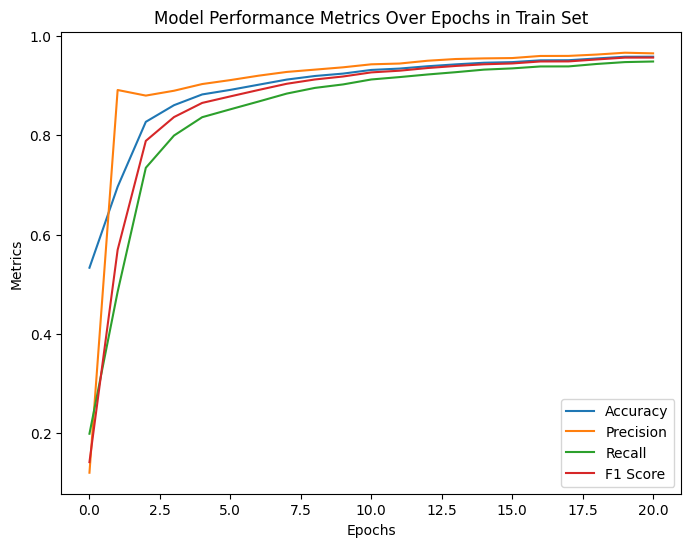

In [8]:
epochs = list(range(0, EPOCHS+1))  # Assuming 20 epochs
accuracy = A_LS
precision = P_LS
recall = R_LS
f1_score = F1_LS

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1_score, label='F1 Score')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Model Performance Metrics Over Epochs in Train Set')
plt.legend()
plt.show()

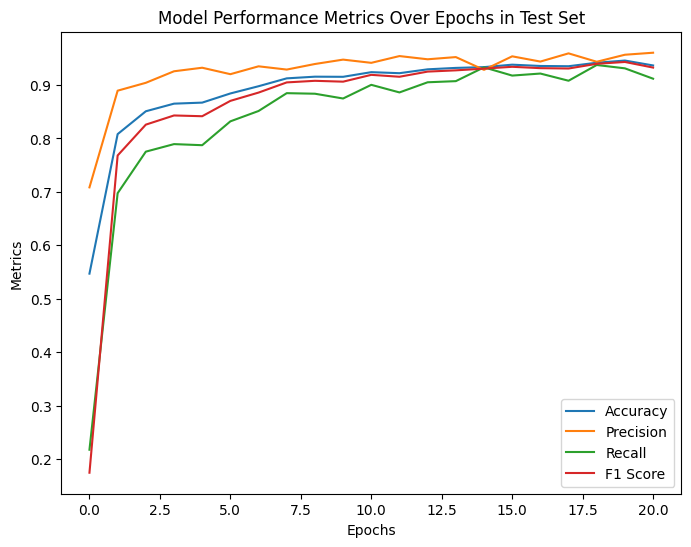

In [9]:
epochs = list(range(0, EPOCHS+1))  # Assuming 20 epochs
accuracy = [float(i) for i in A_LS2]
precision = [float(i) for i in P_LS2]
recall = [float(i) for i in R_LS2]
f1_score = [float(i) for i in F1_LS2]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(epochs, accuracy, label='Accuracy')
plt.plot(epochs, precision, label='Precision')
plt.plot(epochs, recall, label='Recall')
plt.plot(epochs, f1_score, label='F1 Score')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Model Performance Metrics Over Epochs in Test Set')
plt.legend()
plt.show()

### 6. Model Validation

In [10]:
valid_data_x = []
valid_data_id = []
for path in os.listdir(VALID_DATA_PATH):
    image = cv2.imread(VALID_DATA_PATH + path)
    id = int(path.split('(')[1].split(')')[0])
    valid_data_x.append(image)
    valid_data_id.append(id)
output_valid_x = valid_data_x

In [11]:
valid_data_x = np.array(valid_data_x)
print(valid_data_x.shape)
valid_data_x = torch.tensor(np.array(valid_data_x))        
valid_data_id = torch.tensor(np.array(valid_data_id))        
valid_dataset = TensorDataset(valid_data_x, valid_data_id)
data_loader_valid = DataLoader(dataset=valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

(20705, 180, 270, 3)


In [12]:
y_pred_ls = []
probability_ls = []
id_ls = []
img_ls = []
for data in data_loader_valid:
    data_pred = data[0] / 255
    ids = data[1]
    id_ls += ids
    img_ls += data[0]
    y_predict = model(data_pred)
    prob = F.softmax(y_predict ,dim=1)
    probability = torch.tensor([torch.max(_) for _ in prob]).float()
    y_predict = torch.tensor([torch.argmax(_) for _ in y_predict]).float()
    y_pred_ls += y_predict
    probability_ls += probability

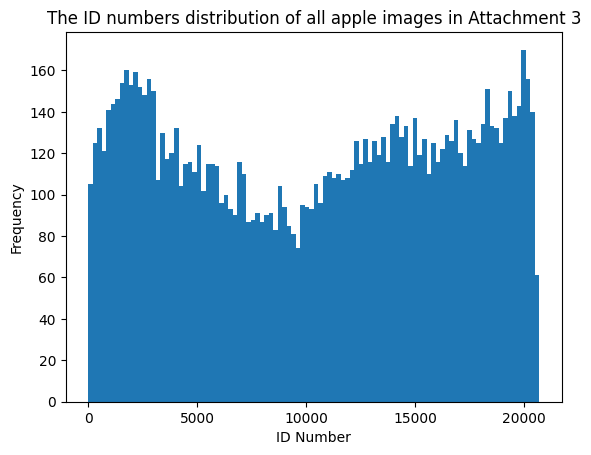

In [13]:
apple_ids = []
for i in range(len(y_pred_ls)):
    if y_pred_ls[i] == 0:
        apple_ids.append(id_ls[i])
apple_ids = np.array(apple_ids)

def histogram(bins):
    bin_num = int(valid_data_x.shape[0] / bins)
    bin_factor = range(1,bin_num+1)
    bin_ls = np.array([bins]*bin_num) * bin_factor
    plt.hist(apple_ids, bins=bins)  # 'bins' defines the number of intervals or bins
    plt.title('The ID numbers distribution of all apple images in Attachment 3')
    plt.xlabel('ID Number')
    plt.ylabel('Frequency')
    plt.show()
    plt.close()
    
histogram(100)


### 7. Output Prediction

[18414, 20286, 10094, 6535, 11512, 2148]


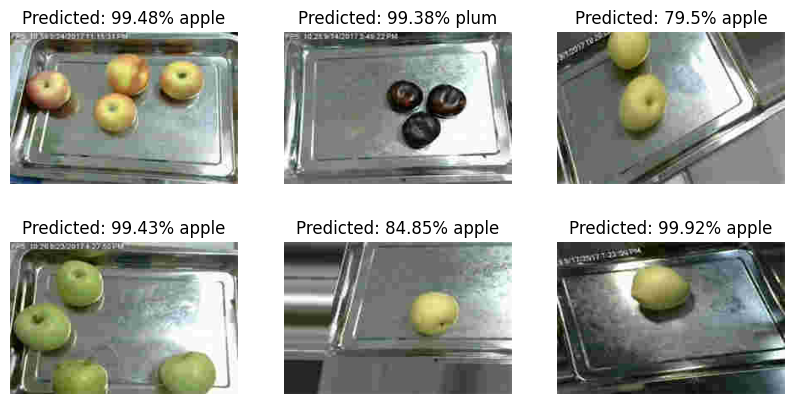

In [14]:
import matplotlib.pyplot as plt
from random import randint
row,column = 2,3
fig = plt.figure(figsize=(10, 5)) 
#index = [20694,20689,13580,13489,1,7817]
index = []
for i in range(6):
    index.append(randint(0,len(valid_data_x)))
print(index)
ink = -1
y_pred_ls = [int(i) for i in y_pred_ls]    
probability_ls = [float(i) for i in probability_ls]    
for i in index:
    ink += 1
    id_temp = id_ls[i]
    img_temp = img_ls[i]
    pred_temp = y_pred_ls[i]
    prob_temp = probability_ls[i]
    fig.add_subplot(row, column, ink+1) 
    rgb = np.array(img_temp, dtype=np.uint8)
    rgb = cv2.cvtColor(rgb,cv2.COLOR_RGB2BGR)
    plt.imshow(rgb) 
    plt.axis('off') 
    class_name = CLASSES[pred_temp]
    prob = round(prob_temp*100,2)
    plt.title("Predicted: "+ str(prob)+"% "+class_name)   
